In [277]:
%load_ext autoreload
%autoreload 2
#import stress
import math
import numpy as np
from matplotlib import pyplot as plt 

# load ECG data
files = ('2018_12_05-10_35_00_ECG.csv.gz',
         '2019_03_29-08_56_55_ECG.csv.gz',
         '2019_04_09-11_04_37_ECG.csv.gz',
         '2019_06_10-10_46_26_ECG.csv.gz',
         '2019_02_15-12_09_23_ECG.csv.gz',
         '2019_04_05-09_33_16_ECG.csv.gz',
         '2019_06_07-11_18_26_ECG.csv.gz',
         '2019_06_14-11_08_30_ECG.csv.gz')
filename = 'ECG/' + files[2]
print('loading '+filename+'...')
ecg = np.genfromtxt(filename, delimiter = ',')
ecg = ecg[1:,1]
#print(ecg)
fs = int(1/5e-3)
print('data loaded')
sec = len(ecg)/fs
print('ECG: %d samples at %d Hz (%02d:%02d:%02d)' % (len(ecg), fs, math.floor(sec/60/60), math.fmod(math.floor(sec/60), 60), math.fmod(sec, 60) ))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading ECG/2019_04_09-11_04_37_ECG.csv.gz...
data loaded
ECG: 701000 samples at 200 Hz (00:58:25)


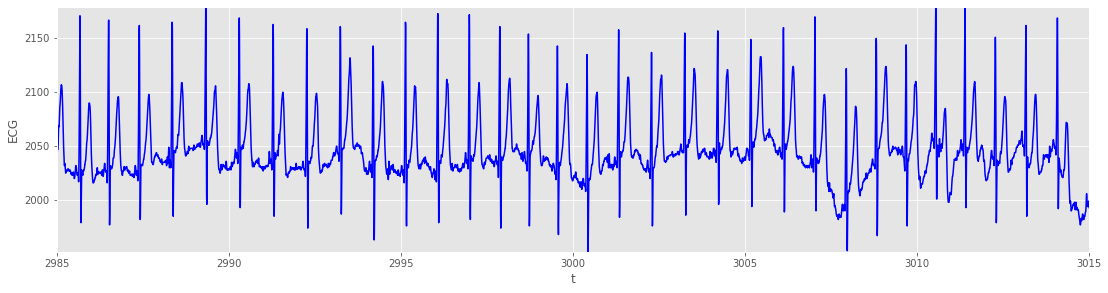

In [278]:

offset = 3000 # seconds
window = 30 # seconds

plt.clf()
#plt.title("Matplotlib demo")
plt.xlabel("t") 
plt.ylabel("ECG")
t = [i/fs for i in range(len(ecg))]
plt.plot(t, ecg, color='b')
plt.xlim(offset-window/2,offset+window/2)
sel = np.arange(int((offset-window/2)*fs),int((offset+window/2)*fs))
plt.ylim(min(ecg[sel]),max(ecg[sel]))

fig = plt.gcf()
fig.set_size_inches(18.5, 4.5)

plt.show()


701000 samples in ECG, 701044 samples in ECG_bp, 701077


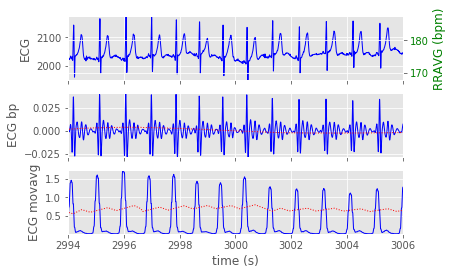

186 QRS complexes found


In [279]:
import stress.panTompkins as pt
# print(stress.panTompkins)
# stress.test()
qrs = pt.panTompkins(ecg, fs, plot = True, decay = 0.99, rravg = 'qrs')
print('%d QRS complexes found'%(len(qrs)))

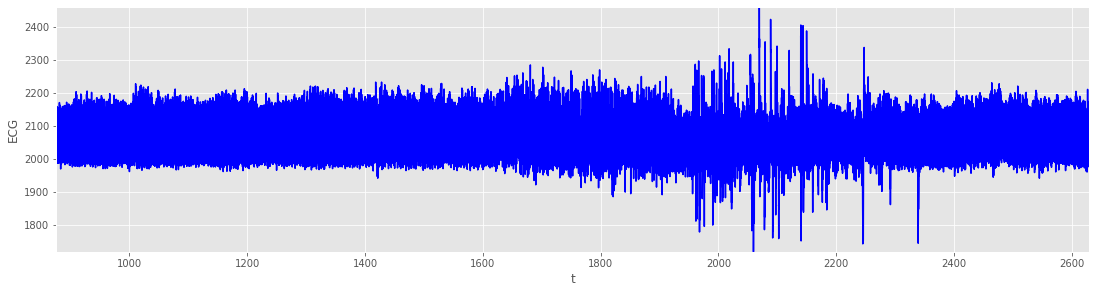

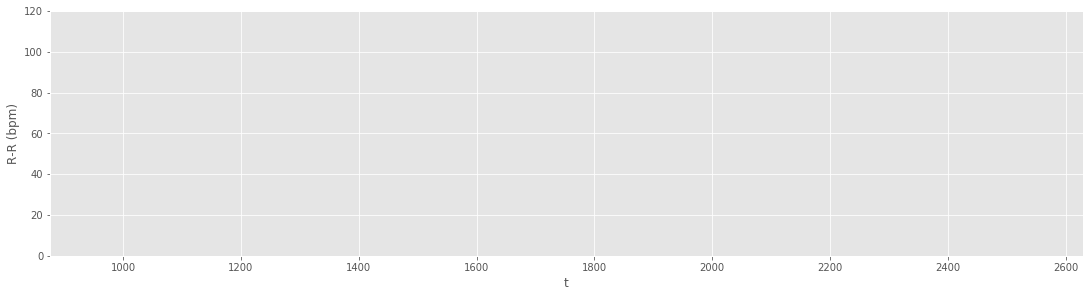

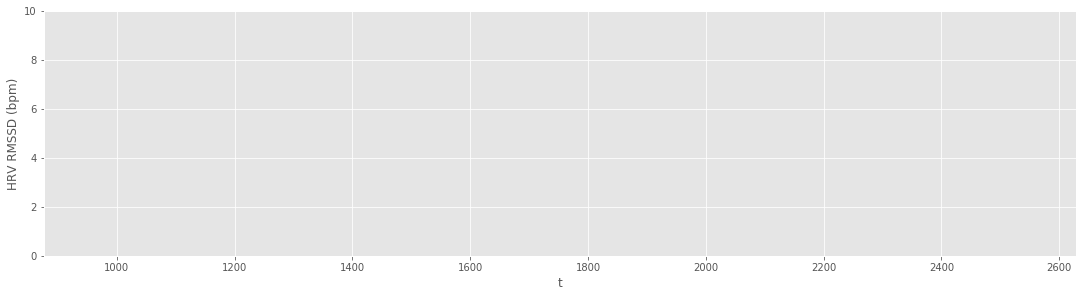

In [280]:
t = [i/fs for i in range(len(ecg))]
t_qrs = [i/fs for i in qrs]
eps = np.finfo(float).eps
bpm = 60/(np.diff(t_qrs) + eps)  # heart rate in beats per minute

# RMSSD: Root Mean Square of Successive Differences between each heartbeat
from numpy.lib.stride_tricks import as_strided
def moving_rmssd(x, window = np.hanning(16)):
    y = np.convolve(window/window.sum(), np.diff(x)**2, mode='valid')
    return np.sqrt(y)
    # stride = seq.strides[0]
    # sequence_strides = as_strided(seq, shape=[len(seq) - window + 1, window], strides=[stride, stride])
    # return np.sqrt(sequence_strides.sum(axis=1))

hrv = moving_rmssd(bpm, window = np.hanning(32))  # heart rate variability in beats per minute

if True:
    offset = t_qrs[-1]/2;
    window = offset
else:
    offset = 3000
    window = 30

plt.clf()
plt.xlabel("t") 
plt.ylabel("ECG")
plt.scatter(t_qrs, ecg[qrs], color='r')
plt.plot(t, ecg, color='b')
plt.xlim(offset-window/2,offset+window/2)
sel = np.arange(int((offset-window/2)*fs),int((offset+window/2)*fs))
plt.ylim(min(ecg[sel]),max(ecg[sel]))
fig = plt.gcf()
fig.set_size_inches(18.5, 4.5)
plt.show()

plt.figure()
plt.xlabel("t") 
plt.ylabel("R-R (bpm)")
x = np.asarray(t_qrs[1:])
sel = np.where(abs(x-offset) < window/2)
plt.plot(x, bpm, color='g', linestyle = 'dashed', marker='o')
plt.xlim(offset-window/2,offset+window/2)
#plt.ylim(min(bpm[sel]),max(bpm[sel]))
plt.ylim(0,120)
fig = plt.gcf()
fig.set_size_inches(18.5, 4.5)
plt.show()

plt.figure()
plt.xlabel("t") 
plt.ylabel("HRV RMSSD (bpm)")
delta = len(t_qrs)-len(hrv)
x = np.asarray(t_qrs[int(delta/2):-(delta-int(delta/2))]) # we centre the RMSSD since we're calculating after the fact
sel = np.where(abs(x-offset) < window/2)
plt.plot(x, hrv, color='r', linestyle = 'dashed', marker='o')
plt.xlim(offset-window/2,offset+window/2)
#plt.ylim(min(hrv[sel]),max(hrv[sel]))
plt.ylim(0,10)
fig = plt.gcf()
fig.set_size_inches(18.5, 4.5)
plt.show()